<a href="https://colab.research.google.com/github/Fritz302/data-science/blob/main/FritKokiU5Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

**Context**

I wanted to see if age is a predictor of body fat percentage. As a person ages, their metabolism slows down which might cause more body fat, but at the same time, I feel like I've observed a lot of frail and skinny older people. This made me want to find out if there is an obvious trend in one direction or the other.

The parameters I'm going to use are the person's age (obviously) and their calculated body fat % via the Siri equation.

You may be asking, what is the Siri equation? The Siri equation is % Body Fat = (495 / Body Density) - 450, with body density being a body's mass divided by its volume.

In [2]:
#load it up
url_bodydata = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/body_fat.csv'
bodydata = pd.read_csv(url_bodydata)

In [3]:
#display chart to get my columns
bodydata

,siri,age,weight,height,abdomen,thigh,wrist
0,12.3,23,70.1,172,85.2,59.0,17.1
1,6.1,22,78.8,184,83.0,58.7,18.2
2,25.3,22,70.0,168,87.9,59.6,16.6
3,10.4,26,84.0,184,86.4,60.1,18.2
4,28.7,24,83.8,181,100.0,63.2,17.7
...,...,...,...,...,...,...,...
246,11.0,70,61.0,170,83.6,49.6,18.5
247,33.6,72,91.4,177,105.0,59.6,20.1
248,29.3,72,84.9,168,111.5,60.3,18.0
249,26.0,72,86.7,179,101.3,56.0,19.8


<Axes: xlabel='age', ylabel='siri'>

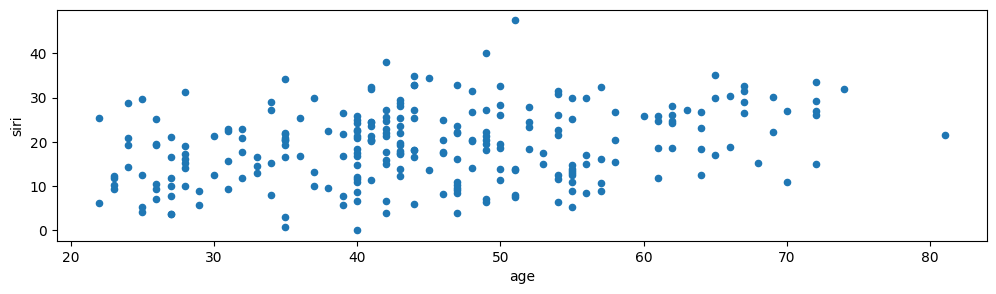

In [4]:
#scatter plot of age v. siri
bodydata.plot(x="age", y="siri", figsize=(12, 3), kind="scatter")

Already, I see a slight upwards linear trend but I'm not entirely confident.

<Axes: ylabel='Frequency'>

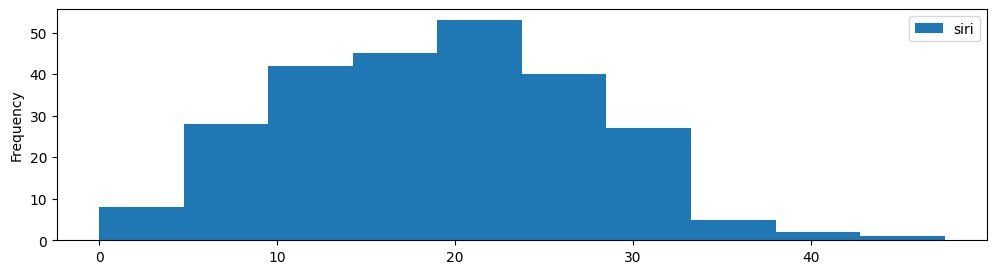

In [8]:
#histogram with frequency of siri
bodydata.plot(x="age", y="siri", figsize=(12, 3), kind="hist")

I did a histogram just so I visualize what siri values are appearing the most and as you can see it looks approximately normal with a mean of about 20. I do notice some high value outliers, but I'll choose to ignore them.

**The Model**

I started by making a linear model based off of my assumptions from the scatterplot.

In [10]:
#ls stands for linear siri
with pm.Model() as model_ls:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #here I tell the model that there is a linear relationship
    μ = pm.Deterministic("μ", α + β * bodydata.age)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=bodydata.siri)

    #inference data object
    idata_ls = pm.sample()

Output()

Output()

In [11]:
# posterior predictive check
pm.sample_posterior_predictive(idata_ls, model=model_ls,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

**Plotting the Posterior Predictive Distribution**

Text(0, 0.5, 'siri values')

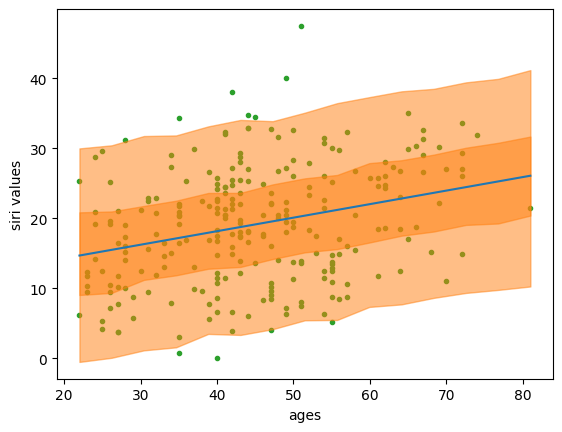

In [12]:
#grabs the expected line, or line of best fit formula
mean_line = idata_ls.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
ages = np.random.normal(bodydata.age.values, 0.01)
idx = np.argsort(ages)
x = np.linspace(ages.min(), ages.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_ls.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(ages[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(bodydata.age, bodydata.siri, "C2.", zorder=-3)
ax.plot(bodydata.age[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for ls, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, ls, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("ages")
ax.set_ylabel("siri values")

Looks pretty solid so now lets test my model.

<Axes: xlabel='y_pred'>

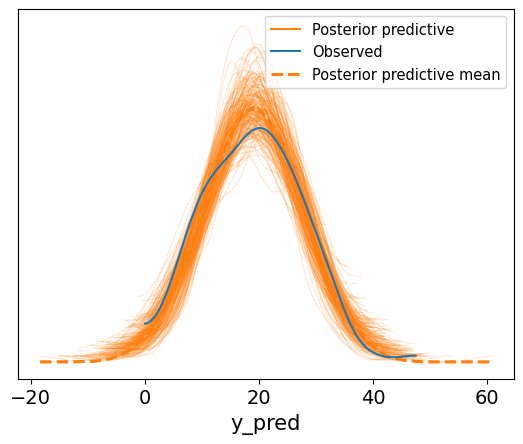

In [13]:
#posterior predictive check
az.plot_ppc(idata_ls, num_pp_samples=200, colors=["C1", "C0", "C1"])

**Conclusion**

Obviously there is a very linear trend between age and body fat %, measured by the siri equation. On my first try of a linear model, I got a really close match to the observed data. The only inaccuracies I notice are the fact that the model is predicting negative siri values (which are impossible), and the model is failing to capture the little bump in the data as it's approaching its peak.

This means that as one ages, they tend to have a higher body fat %, yet it is not an extreme change.